<a href="https://colab.research.google.com/github/bylehn/auxetic_networks_jaxmd/blob/abhishek/test-auxetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax.numpy as np
from jax import random
from jax import ops
from jax.config import config; config.update("jax_enable_x64", True)
from jax_md import space, energy, minimize, simulate, quantity
from jax import random
from jax import jit
import networkx as nx
import numpy as onp
from scipy.spatial import Delaunay
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:
def plot_configuration(node_positions, bond_array, box_size):
    # Create an empty plot
    fig, ax = plt.subplots()

    # Plot the node positions
    for i, position in enumerate(node_positions):
        ax.scatter(position[0], position[1], s=50, c='red', label='Node')

    # Plot the bonds
    for bond in bond_array:
        start_node = node_positions[bond[0]]
        end_node = node_positions[bond[1]]
        ax.plot([start_node[0], end_node[0]], [start_node[1], end_node[1]], 'b-', linewidth=2, label='Bond')


    # Customize the plot
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)

    # Show the plot
    plt.show()

In [2]:
def createDelaunayGraph(NS, rseed, r_c, del_x):

    # This function creates a Delaunay graph of a set of points.

    # Parameters:
    #   NS: The number of points to generate.
    #   rseed: The random seed to use.
    #   r_c: The radius of the circumcircle of each edge in the graph.
    #   del_x: max noise magnitude from square lattice

    # Returns:
    #   N: The number of points in the graph.
    #   G: The graph object.
    #   X: The coordinates of the points.
    #   E: The edges of the graph.

    # Set the random seed.
    onp.random.seed(rseed)

    # Generate the points.
    xm, ym = onp.meshgrid(onp.arange(1, NS + 1), onp.arange(1, NS + 1))
    X = onp.vstack((xm.flatten(), ym.flatten())).T
    N = X.shape[0]

    # Add some noise to the points.
    X = X + del_x * 2 * (0.5 - onp.random.rand(N, 2))

    # Create the Delaunay triangulation.
    DT = Delaunay(X)

    # Get the edges of the triangulation.
    ET = onp.empty((0, 2), dtype=int)
    for T in DT.simplices:
        ET = onp.vstack((ET, [T[0], T[1]], [T[1], T[2]], [T[0], T[2]]))

    # Sort the edges.
    ET = onp.sort(ET)

    # Get the radii of the circumcircles of the edges.
    R = onp.linalg.norm(X[ET[:, 0], :] - X[ET[:, 1], :], axis=1)

    # Keep only the edges with radii less than r_c.
    EN = ET[R < r_c, :]

    # Create the adjacency matrix.
    A = onp.zeros((N, N))
    A[EN[:, 0], EN[:, 1]] = 1

    # Get the lengths of the edges.
    L = onp.linalg.norm(X[ET[:, 0], :] - X[ET[:, 1], :], axis=1)

    # Keep only the edges with lengths less than r_c.
    EL = L[R < r_c]

    # Create the graph object.
    G = nx.Graph(A)

    # Get the edges of the graph.
    E = onp.array(G.edges)

    # Get the lengths of the edges.
    L = onp.linalg.norm(X[E[:, 0], :] - X[E[:, 1], :], axis=1)

    return N, G, X, E, L

def getSurfaceNodes(G, NS):
    # Retrieve the list of nodes in the graph G
    nodes = np.array(list(G.nodes))
    # Calculate the x and y coordinates of the nodes based on the grid size NS
    x_values = nodes % NS
    y_values = nodes // NS
    # Find the nodes located on the top surface (y = NS - 1)
    top_nodes = nodes[y_values == NS - 1]
    # Find the nodes located on the bottom surface (y = 0)
    bottom_nodes = nodes[y_values == 0]
    # Find the nodes located on the left surface (x = 0)
    left_nodes = nodes[x_values == 0]
    # Find the nodes located on the right surface (x = NS - 1)
    right_nodes = nodes[x_values == NS - 1]
    # Return a dictionary with surface names as keys and node arrays as values
    return {
        'top': top_nodes,
        'bottom': bottom_nodes,
        'left': left_nodes,
        'right': right_nodes
    }

In [3]:
#create graph
N,G,X,E,L =createDelaunayGraph(10, 25, 2.0, 0.4)

In [76]:
# Define the system parameters in JAX

# Convert the NetworkX graph into an adjacency matrix
adj_matrix = nx.to_numpy_array(G)

# Convert the adjacency matrix into a JAX MD system
R = np.array(X)  # Coordinates of the points
N = R.shape[0]   # Number of points
species = np.zeros(N, dtype=np.int32)  # All points belong to the same species in this example

# Calculate the maximum extent in each dimension
avg_left = np.mean(R[left_indices], axis=0)
avg_right = np.mean(R[right_indices], axis=0)
avg_bottom = np.mean(R[bottom_indices], axis=0)
avg_top = np.mean(R[top_indices], axis=0)
max_extent = max(avg_right[0] - avg_left[0], avg_top[1] - avg_bottom[1])

# Determine the box length based on the maximum extent and the desired cutoff radius
r_c = 2.0  # Set the desired cutoff radius
box_length = np.max(max_extent) + 1 * r_c

# Define the displacement and shift functions for the periodic system.
displacement, shift = space.free() #displacement = points in space, shift = small shifts of each particle


In [77]:
bond_array = np.array(E)

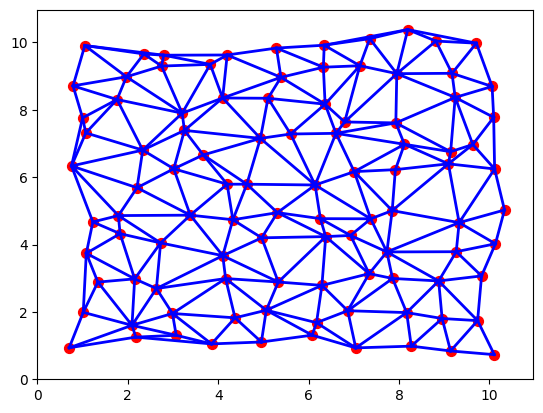

In [9]:
plot_configuration(R, bond_array, box_length)

In [78]:
def createSpringConstants(X,E,k_1):
    #k_1 is the spring constant for a spring of unit length
    displacements=X[E[:,0],:]-X[E[:,1],:]
    distance=np.linalg.norm(displacements,axis=1)
    return k_1/distance,distance

In [79]:
k_bond = createSpringConstants(X,E,1.0)[0]
k_bond

Array([0.66367074, 0.91107153, 0.64859913, 1.11623286, 0.59271367,
       2.77416272, 1.21675997, 0.97909521, 1.53397484, 0.90544131,
       0.80048006, 1.0720311 , 0.87617009, 1.08178139, 1.05230611,
       0.96554663, 0.7958211 , 2.61375473, 0.81358505, 0.87281369,
       0.89463411, 0.65024777, 1.13584594, 0.99884574, 0.93726021,
       1.02676906, 1.01934428, 0.92509021, 0.92969306, 0.87318759,
       1.04843912, 0.56999452, 1.04022544, 0.6720149 , 0.72469385,
       0.82119831, 0.71952399, 1.21744066, 0.63798911, 1.3756833 ,
       0.84417549, 0.85351667, 0.76875009, 1.13970972, 0.69719729,
       1.28892342, 0.89810641, 0.76626014, 1.05988862, 0.8347837 ,
       0.72538828, 1.24400144, 0.94318074, 0.85048015, 1.27029318,
       0.89512017, 0.6855077 , 0.75207313, 1.21950834, 1.11968126,
       1.78527207, 0.76225926, 0.72499612, 0.82561239, 0.64159273,
       0.73687778, 0.56752698, 0.85472413, 1.46657134, 1.03074311,
       0.68668159, 0.73407247, 0.58536012, 0.90818334, 0.68936

In [80]:
energy_fn = energy.simple_spring_bond(displacement, E, length=L, epsilon=k_bond)
force_fn = quantity.force(energy_fn)  #calculates gradients 

In [117]:
#initial minimization
print_every = 10
fire_init, fire_apply = minimize.fire_descent(energy_fn, shift)
fire_apply = jit(fire_apply)
fire_state = fire_init(R)

energy_traj = []
traj = []

for step in range(100):
  fire_state = fire_apply(fire_state)

  energy_traj += [energy_fn(fire_state.position)]
  traj += [fire_state.position]
  if step % print_every == 0:
        R = fire_state.position
        print('{:.2f}\t{:.2f}\t{:.2f}'.format(step, energy_fn(R), np.max(force_fn(R))))

R_initial = fire_state.position
traj = np.stack(traj)

0.00	0.00	0.00
10.00	0.00	0.00
20.00	0.00	0.00
30.00	0.00	0.00
40.00	0.00	0.00
50.00	0.00	0.00
60.00	0.00	0.00
70.00	0.00	0.00
80.00	0.00	0.00
90.00	0.00	0.00


In [18]:


fire_init, fire_apply = minimize.fire_descent(modified_force_fn, shift)

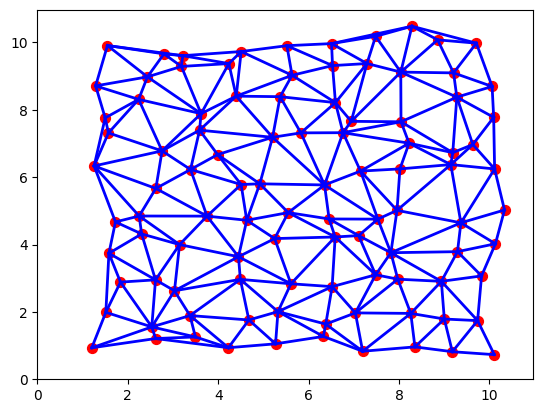

In [20]:
plot_configuration(R, bond_array, box_length)

In [109]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Convert the trajectory to a NumPy array
trajectory_array = np.array(traj_shifted)

# Create a subplot for the scatter plot
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter'}]], print_grid=False)

# Create a scatter plot using Plotly
trace = go.Scatter(x=trajectory_array[:, 0], y=trajectory_array[:, 1], mode='markers')
fig.add_trace(trace)

# Create and add slider
steps = []
for i, frame in enumerate(trajectory_array):
    step = dict(
        method="update",
        args=[
            {"x": [frame[:, 0]], "y": [frame[:, 1]]},
        ],
        label=str(i),
    )
    steps.append(step)

slider = dict(steps=steps, active=0, pad={"t": 50}, currentvalue={"prefix": "Frame: "})

fig.update_layout(sliders=[slider])

# Update the layout
fig.update_layout(
    width=600,
    height=600,
    xaxis=dict(title='X', showgrid=False),
    yaxis=dict(title='Y', showgrid=False),
    plot_bgcolor='rgba(255, 255, 255, 1)', # White background
    margin=dict(l=50, r=50, b=50, t=50) # Adjust margin if needed
)

fig.show()


In [122]:
# Constants representing source and target points.
source_idx = [6, 27]
target_idx = [91, 83]

def compute_distance(point1, point2):
    """
    Calculate the Euclidean distance between two points.
    """
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

def fitness(source_strain, target_strain, goal_strain):
    """
    Calculate the fitness based on the strains.
    """
    eta = target_strain / source_strain
    return np.abs(1 - eta / goal_strain)

def displace_sources(R, source_idx, delta):
    """
    Adjust the R of two source points along their connecting vector.
    """
    source_vector = R[source_idx[1], :] - R[source_idx[0], :]
    unit_vector = source_vector / np.linalg.norm(source_vector)
    
    # Displace both source points along the unit vector, half the delta in opposite directions.
    displacement = 0.5 * delta * unit_vector
    R = R.at[sources[0], :].set(R[source_idx[0]] - displacement)
    R = R.at[sources[1], :].set(R[source_idx[1]] + displacement)
    return R

def obtain_strain(initial_R, final_R, source_idx, target_idx):
    """
    Calculate the strains for the source and target regions based on initial and final R.
    """
    # Extract R for source and target regions.
    initial_source_R = initial_R[source_idx, :]
    final_source_R = final_R[source_idx, :]
    initial_target_R = initial_R[target_idx, :]
    final_target_R = final_R[target_idx, :]

    # Calculate distances for initial and final configurations.
    d_source_initial = compute_distance(initial_source_R[0], initial_source_R[1])
    d_source_final = compute_distance(final_source_R[0], final_source_R[1])
    d_target_initial = compute_distance(initial_target_R[0], initial_target_R[1])
    d_target_final = compute_distance(final_target_R[0], final_target_R[1])

    # Calculate the strains.
    source_strain = (d_source_final - d_source_initial) / d_source_initial
    target_strain = (d_target_final - d_target_initial) / d_target_initial

    return source_strain, target_strain


def constrained_force_fn(R, source_idx):
    """
    Calculates forces with frozen sources.
    """
    total_force = force_fn(R)
    total_force = total_force.at[source_idx, :].set(0.0)
    
    return total_force


In [ ]:
def simulate_allostery(R, E, source_idx, target_idx, eta_star, ds):
    R_init = minimize_config(R, energy_fn, free_force_fn, etol, max_steps)
    R_new = displace_sources(R_init, source_idx, ds)
    R_final = minimize_config(R_new, constrained_forces_fn, etol, max_steps)
    source_strain, target_strain = obtain_strain(R_init, R_final, source_idx, target_idx)
    fitness = fitness(source_strain, target_strain, goal_strain=1)

    

In [ ]:
def minimize_config(R, energy_fn, force_fn, etol, max_steps):
    displacement, shift = space.free() #displacement = points in space, shift = small shifts of each particle
    fire_init, fire_apply = minimize.fire_descent(force_fn, shift)
    fire_state = fire_init(R_new)

    # Running the minimization
    energies = []
    trajectory = []
    for step in range(max_steps):
      fire_state = fire_apply(fire_state)

      energies += [force_fn(fire_state.position)]
      traj_shifted += [fire_state.position]
      if step % print_every == 0:
            R = fire_state.position
            print('{:.2f}\t{:.2f}\t{:.2f}'.format(step, energy_fn(R), np.max(force_fn(R))))
      
      if energy_fn(R) <= etol:
        break

    R_final = fire_state.position
    traj_shifted = np.stack(traj_shifted)